## Burger's Equation

### (1) Problem Description
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in [-1,1],\ t\in(0,1] 
\end{equation}
We set $\nu=0.1/\pi$ and consider the periodic boundary condition here, i.e.:
$$
u(-1, t) = u(1, t)=0,\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

### (2) The MultiONet method (Batch)
[DGenNO: A Novel Physics-aware Neural Operator for Solving Forward and Inverse PDE Problems based on Deep, Generative Probabilistic Modeling](https://arxiv.org/pdf/2502.06250)

**Batch Type:** the input $x$ has size **(batch_size, mesh_size, dim)** and the input $a$ has size **(batch_size, latent_size)**.

### (2.1) Prepare data

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py
import torch 
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32

######################################
# Load training data
######################################
from Utils.utils import *
#
def get_data(data, dtype):
    a = np2tensor(np.array(data["u0"]).T, dtype)
    u = np2tensor(np.array(data["u_sol"]).T, dtype)
    uT = u[:,-1,:]
    #
    ndata = a.shape[0]
    x_mesh = np2tensor(np.array(data['x_mesh']))
    #
    a = a.reshape(ndata, -1)
    uT = uT.reshape(ndata, -1)
    x = x_mesh.reshape(1, -1, 1).repeat(ndata,1,1)
    
    return a, uT, x, x_mesh
#
data_train = h5py.File('./dataset/viscid_train.mat', 'r')
data_test = h5py.File('./dataset/viscid_test_in.mat', 'r')
a_train, uT_train, x_train, gridx_train = get_data(data_train, dtype)
a_test, uT_test, x_test, gridx_test = get_data(data_test, dtype)
#
print('The shape of a_train:', a_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of x_train:', x_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
#
print('The shape of a_test:', a_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
########################################
from Utils.PlotFigure import Plot
# inx = 0
# #
# Plot.show_1d_list(x_train[inx], [a_train[i*10+1] for i in range(5)], ['a0_train']*5, lb =-1.)
# Plot.show_1d_list(x_train[inx], [uT_train[i*10+1] for i in range(5)], ['uT_train']*5, lb =-1.)

The shape of a_train: torch.Size([1000, 128])
The shape of uT_train: torch.Size([1000, 128])
The shape of x_train: torch.Size([1000, 128, 1])
The shape of gridx_train: torch.Size([128, 1])
The shape of a_test: torch.Size([200, 128])
The shape of uT_train: torch.Size([200, 128])
The shape of x_test: torch.Size([200, 128, 1])
The shape of gridx_test: torch.Size([128, 1])


### (2.2) Define the loss class

In [3]:
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']

    def Loss_data(self, a, u, x):
        ''' '''
        u_pred = self.model_u(x, a)
        #
        loss = self.solver.getLoss(u_pred, u)
        
        return loss

    def Error(self, a, u, x):
        ''' '''
        u_pred = self.model_u(x, a)
        #
        err = self.solver.getError(u_pred, u)
        
        return err

######################################
# Steups of the model
######################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
netType = 'MultiONetBatch'
#
trunk_layers, trunk_activation = [128]*5, 'SiLU_Sin'
branch_layers, branch_activation = [128]*5, 'SiLU'
model_u = solver.getModel(x_in_size=1, a_in_size=a_train.shape[1], 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk=trunk_activation, activation_branch=branch_activation, 
                          netType='Batch')
# ###############################
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} trainable parameters.')

148,869 trainable parameters.


### (2.3) Training the model

In [4]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=5e-4, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=0.5, step_size=np.int32(2000/5))
solver.train_batch(LossClass, a_train, uT_train, x_train, a_test, uT_test, x_test, 
                   batch_size=50, epochs=2000, epoch_show=100, **{'save_path':f'saved_models/{netType}/'})

  5%|██▊                                                     | 101/2000 [00:10<03:37,  8.73it/s]

Epoch:100 Time:10.8129, loss_train:0.010952, loss_test:0.011777
          lr: 0.0005 err_test 0.01644076593220234


 10%|█████▋                                                  | 201/2000 [00:22<03:26,  8.73it/s]

Epoch:200 Time:22.3188, loss_train:0.007523, loss_test:0.008917
          lr: 0.0005 err_test 0.011868316680192947


 15%|████████▍                                               | 301/2000 [00:33<03:14,  8.76it/s]

Epoch:300 Time:33.7664, loss_train:0.007380, loss_test:0.006877
          lr: 0.0005 err_test 0.00972902961075306


 20%|███████████▎                                            | 402/2000 [00:44<02:18, 11.54it/s]

Epoch:400 Time:44.6882, loss_train:0.006019, loss_test:0.005535
          lr: 0.00025 err_test 0.0077026705257594585


 25%|██████████████                                          | 501/2000 [00:54<02:53,  8.64it/s]

Epoch:500 Time:54.5980, loss_train:0.005179, loss_test:0.003534
          lr: 0.00025 err_test 0.004608778282999992


 30%|████████████████▊                                       | 601/2000 [01:06<02:41,  8.64it/s]

Epoch:600 Time:66.1589, loss_train:0.003980, loss_test:0.003270
          lr: 0.00025 err_test 0.004528438206762075


 35%|███████████████████▋                                    | 701/2000 [01:17<02:30,  8.64it/s]

Epoch:700 Time:77.7883, loss_train:0.003600, loss_test:0.003713
          lr: 0.00025 err_test 0.004728775471448898


 40%|██████████████████████▍                                 | 801/2000 [01:29<02:20,  8.54it/s]

Epoch:800 Time:89.4001, loss_train:0.002867, loss_test:0.004335
          lr: 0.000125 err_test 0.00576587300747633


 45%|█████████████████████████▏                              | 901/2000 [01:41<02:08,  8.58it/s]

Epoch:900 Time:101.0314, loss_train:0.002038, loss_test:0.002408
          lr: 0.000125 err_test 0.003158817533403635


 50%|███████████████████████████▌                           | 1001/2000 [01:52<01:56,  8.56it/s]

Epoch:1000 Time:112.6762, loss_train:0.002164, loss_test:0.002718
          lr: 0.000125 err_test 0.003516080789268017


 55%|██████████████████████████████▎                        | 1101/2000 [02:04<01:45,  8.50it/s]

Epoch:1100 Time:124.3774, loss_train:0.001822, loss_test:0.002044
          lr: 0.000125 err_test 0.0027378438971936703


 60%|█████████████████████████████████                      | 1201/2000 [02:15<01:30,  8.83it/s]

Epoch:1200 Time:135.8224, loss_train:0.002307, loss_test:0.002840
          lr: 6.25e-05 err_test 0.0038175468798726797


 65%|███████████████████████████████████▊                   | 1301/2000 [02:27<01:18,  8.88it/s]

Epoch:1300 Time:147.1196, loss_train:0.001435, loss_test:0.002149
          lr: 6.25e-05 err_test 0.0026629792992025614


 70%|██████████████████████████████████████▌                | 1401/2000 [02:38<01:07,  8.88it/s]

Epoch:1400 Time:158.3867, loss_train:0.001340, loss_test:0.001754
          lr: 6.25e-05 err_test 0.0022086056414991617


 75%|█████████████████████████████████████████▎             | 1501/2000 [02:49<00:55,  9.03it/s]

Epoch:1500 Time:169.6432, loss_train:0.001358, loss_test:0.001699
          lr: 6.25e-05 err_test 0.002188231563195586


 80%|████████████████████████████████████████████           | 1601/2000 [02:58<00:29, 13.55it/s]

Epoch:1600 Time:178.4236, loss_train:0.001462, loss_test:0.001666
          lr: 3.125e-05 err_test 0.002141760429367423


 85%|██████████████████████████████████████████████▊        | 1701/2000 [03:05<00:21, 13.71it/s]

Epoch:1700 Time:185.8617, loss_train:0.001263, loss_test:0.001699
          lr: 3.125e-05 err_test 0.0021156538277864456


 90%|█████████████████████████████████████████████████▌     | 1801/2000 [03:16<00:23,  8.59it/s]

Epoch:1800 Time:196.7648, loss_train:0.001180, loss_test:0.001523
          lr: 3.125e-05 err_test 0.0018663021037355065


 95%|████████████████████████████████████████████████████▎  | 1901/2000 [03:28<00:11,  8.92it/s]

Epoch:1900 Time:208.1248, loss_train:0.001218, loss_test:0.001754
          lr: 3.125e-05 err_test 0.0022142594680190086


100%|███████████████████████████████████████████████████████| 2000/2000 [03:36<00:00,  9.25it/s]

Epoch:2000 Time:216.1624, loss_train:0.001205, loss_test:0.001584
          lr: 1.5625e-05 err_test 0.002063526539131999
The total training time is 216.1667


### (3) load trained model and make prediction

The test l2 error: tensor(0.0021)


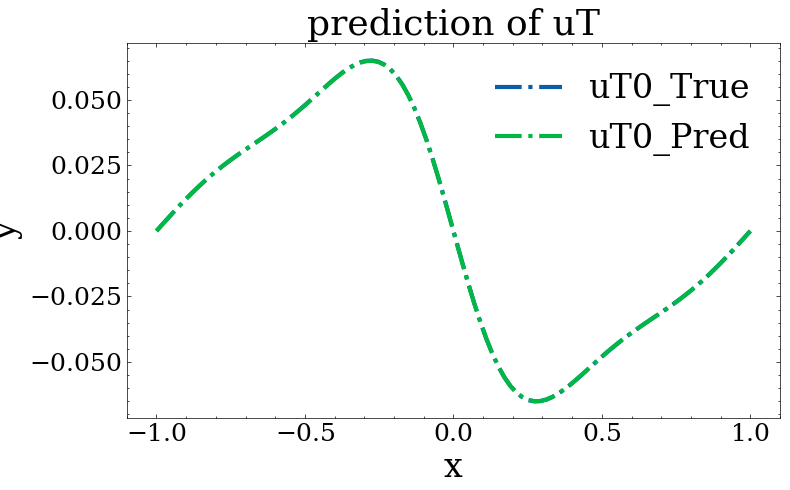

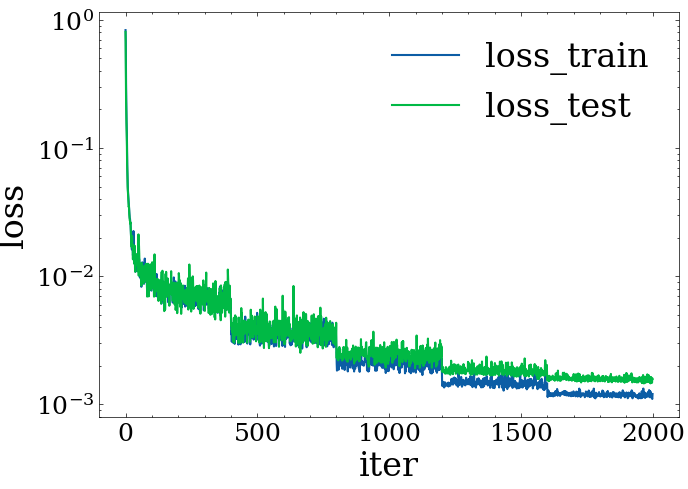

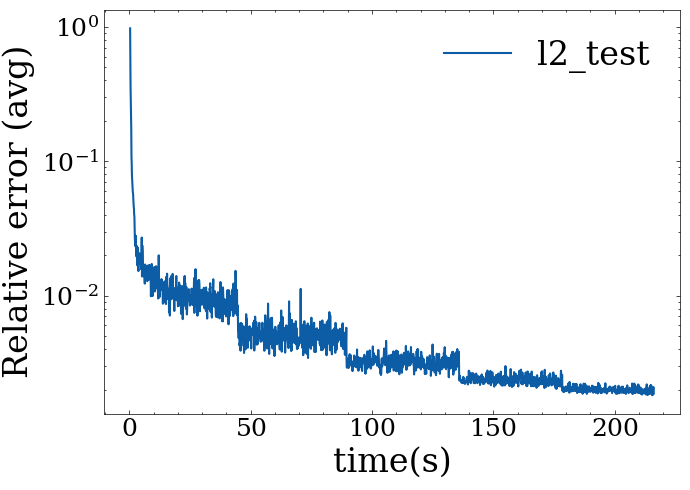

In [5]:
#####################################
# Load the trained model
#####################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', name='model_multionet_final')

#########################################
data_test = h5py.File('./dataset/viscid_test_in.mat', 'r')
a_test, uT_test, x_test, gridx_test = get_data(data_test, dtype)
#
with torch.no_grad():
    uT_pred = model_trained['u'](x_test.to(device), a_test.to(device))
    uT_pred = uT_pred.detach().cpu()
print('The test l2 error:', solver.getError(uT_pred, uT_test))

# ########################################
from Utils.PlotFigure import Plot
inx = 0
# show prediction
Plot.show_1d_list(gridx_test, [uT_test[inx], uT_pred[inx]], 
                  label_list=['uT0_True', 'uT0_Pred'], title='prediction of uT')
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_multionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']], [loss_saved['l2_test']], ['l2_test'])